<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

You built an image classification model, evaluated it on a validation set and got a decent accuracy. Now you deploy the model for the real-world scenario. And soon, you may find that the model performs worse than expected.

This is quite common scenario (and inevitable) when we build a machine learning model because we cannot collect all the possible samples. Your model is supposed to learn the features that describe the target classes the best, but in reality, it learns the best features **to classify your dataset**. For example, if we have *carton* photos with white background only, the model may learn the background color to classify *carton* objects.

<img src="./media/hard_neg_ex1.jpg" width="400"> | <img src="./media/hard_neg_ex2.jpg" width="400"> 
---|---
Did our model learn a butterfly? | or yellow flowers?

Hard negative sampling (or hard negative mining) is a useful technique to address this pitfall. It is a way to explicitly create examples for your training set from falsely classified samples. The technique is widely used when you cannot add all the negative samples since (i) training time would get too slow because of too many training samples; and (ii) many of the negative images are trivial for the model and hence the model would not learn anything. Therefore, we try to identify the images which make a difference when added to the training set.

In this notebook, we train our model on a training set as usual, test the model on un-seen negative examples and see if the model classifies them correctly. If not, we introduce those samples into the training set and re-train the model on them.

Training workflow is as follows:
1. Prepare training set `T` and negative-sample set `U`
2. Load a pre-trained ImageNet model
3. Train the model on `T`
4. Score the model on `U`
5. Identify hard images in `U`
6. Annotate the hard samples and add to `T`
7. Repeat step 3-6 if needed

Let's get started.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial 
import os
from pathlib import Path
import sys
sys.path.append("../../")
import shutil
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
# fastai
import fastai
from fastai.vision import (
    # data-modules
    CategoryList, DatasetType, get_image_files, ImageList, imagenet_stats,
    # model-modules
    cnn_learner, models, ClassificationInterpretation, 
)
from fastai.metrics import accuracy

from utils_cv.classification.model import (
    IMAGENET_IM_SIZE as IMAGE_SIZE,
    TrainMetricsRecorder
)
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.common.image import show_im_files
from utils_cv.common.misc import copy_files, set_random_seed
from utils_cv.common.plot import line_graph

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 11430 / 11441 (MiB)


In [3]:
SEED          = 10
NEGATIVE_NUM  = 10  # Number of negative samples to add
EPOCHS_HEAD   = 4
EPOCHS_BODY   = 12
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
# Using fast_inference parameters from 02_training_accuracy_vs_speed notebook.
ARCHITECTURE  = models.resnet18
IM_SIZE       = 300 

## 1. Prepare datasets

Our goal is to train a classifier which can recognize *fridge obejcts* (`watter_bottle`, `carton`, `can`, and `milk_bottle`), similar to [01_train notebook](./01_training_introduction.ipynb). However, the input image might not even contain any of these objects in the real use-case. Therefore, we also introduce a negative class.

First, let's see how the new datasets look like.

In [4]:
datapath = Path(unzip_url(Urls.fridge_objects_path, exist_ok=True))
negative_datapath = Path(unzip_url(Urls.unlabeled_objects_path, exist_ok=True))

data_list = (ImageList.from_folder(fridge_datapath)
             .split_by_rand_pct(valid_pct=0.2, seed=SEED)
             .label_from_folder())
negative_list = (ImageList.from_folder(negative_datapath)
                 .split_by_rand_pct(valid_pct=0.2, seed=SEED))

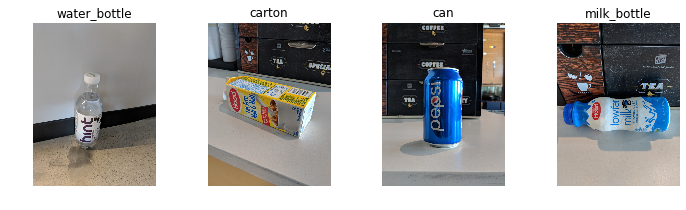

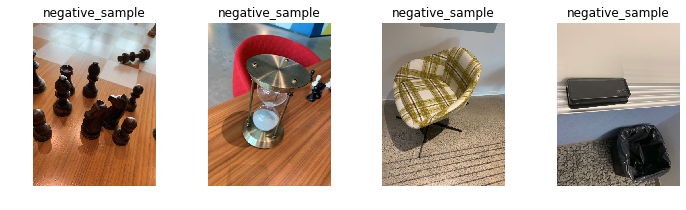

In [5]:
fridge_object_im_files = [
    get_image_files(fridge_datapath/'water_bottle')[0],
    get_image_files(fridge_datapath/'carton')[0],
    get_image_files(fridge_datapath/'can')[0],
    get_image_files(fridge_datapath/'milk_bottle')[0],
]


negative_im_files = get_image_files(negative_datapath)[:4]

show_im_files(fridge_object_im_files, ['water_bottle', 'carton', 'can', 'milk_bottle'])
show_im_files(negative_im_files, ['negative_sample']*4)

Let's prepare our dataset in the following way:
* The initial training set `T` to include *fridge objects* as well as **some of** *negative* images.
* Negative set `U`.
* Validation set `V` to have both *fridge objects* and *negative*. We evaluate our model on this set.

In [6]:
tmpdir = TemporaryDirectory()
data_path = Path(tmpdir.name)/'data'

# Training set T
copy_files(fridge_objects.train.items, data_path/'train', infer_subdir=True)
copy_files(negatives.train.items[:1], data_path/'train'/'negative')  # add 1 negative image to initial training set.

# Validation set V
copy_files(fridge_objects.valid.items, data_path/'valid', infer_subdir=True)
copy_files(negatives.valid.items, data_path/'valid'/'negative')

# Test set, in our case, it is U (negative data)
copy_files(negatives.train.items[1:], data_path/'test')

In [7]:
data = (ImageList.from_folder(data_path)
        .split_by_folder()
        .label_from_folder()
        .add_test_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))
print(f'number of classes: {data.c} = {data.classes}')
print(data.batch_stats)

number of classes: 5 = ['can', 'carton', 'milk_bottle', 'negative', 'water_bottle']
<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (109 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negative,carton,carton,carton,carton
Path: /tmp/tmps0ewsrvt/data;

Valid: LabelList (38 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negative,negative,negative,negative,negative
Path: /tmp/tmps0ewsrvt/data;

Test: LabelList (51 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /tmp/tmps0ewsrvt/data>


> Note, test set doesn't have labels (`EmptyLabelList`)

## 2. Prepare a model

We use *fast inference* setup we demonstrated from [02_training_accuracy_vs_speed notebook](./02_training_accuracy_vs_speed.ipynb). The model is Resnet18 and pre-trained on [ImageNet](http://www.image-net.org/).

In [8]:
learn = cnn_learner(data, ARCHITECTURE, metrics=accuracy)

Because we replace the last layer of the pre-trained model to the new one that fits to our problem, the loss will be large in the beginning of the training. This will result in updating the weights in the rest of the layers a lot, end up breaking all the pre-trained information. To prevent this, we first only train the last layer for a few epochs.

In [9]:
learn.fit_one_cycle(EPOCHS_HEAD, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy,time
0,2.034435,1.702159,0.236842,00:03
1,1.919255,1.574314,0.236842,00:01
2,1.903165,1.568669,0.184211,00:01
3,1.866153,1.585287,0.263158,00:01


In [10]:
# Records train and valid accuracies by using Callback TrainMetricsRecorder
learn.callbacks.append(TrainMetricsRecorder(learn, show_graph=True))
learn.unfreeze()

In [11]:
# We store train and valid accuracies for later analysis
train_acc = []
valid_acc = []
interpretations = []

## 3. Train the model on *T*

<a id='train'></a>

From this section to the end, we do training and negative mining. You may need to do it once or repeat several times to achieve good results depending on your dataset and problem.

In [47]:
# Show the number of repetitions you went through the negative mining
print(f"Ran {len(interpretations)} time(s)")

Ran 3 time(s)


epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,0.219631,0.564739,0.921875,0.868421,00:02
1,0.196433,0.530408,0.937500,0.868421,00:02
2,0.168148,0.480547,0.968750,0.947368,00:02
3,0.134884,0.424565,1.000000,0.973684,00:02
4,0.117453,0.369552,0.992188,0.973684,00:02
5,0.098918,0.362566,1.000000,0.973684,00:02
6,0.086590,0.348955,0.992188,0.973684,00:02
7,0.077338,0.337091,1.000000,0.973684,00:02
8,0.068986,0.339752,1.000000,0.973684,00:02
9,0.060877,0.343582,1.000000,0.973684,00:02


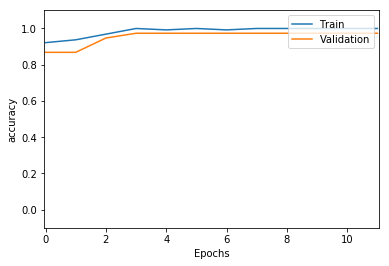

In [35]:
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

The following cell shows confusion matrix for the validation set. If you are repeating the negative mining steps, you will see all the confusion matrices from the repetitions.

In [36]:
interpretations.append(ClassificationInterpretation.from_learner(learn))

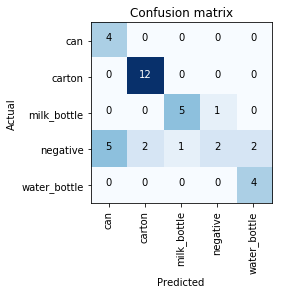

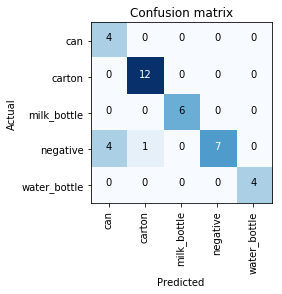

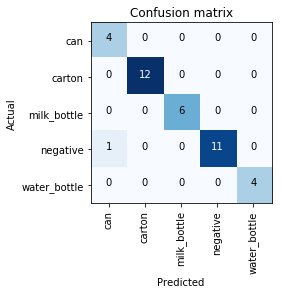

In [37]:
for i, interp in enumerate(interpretations):
    interp.plot_confusion_matrix()

In [38]:
# Store train and valid accuracy
train_acc.extend(np.array(learn.train_metrics_recorder.train_metrics)[:, 0])
valid_acc.extend(np.array(learn.train_metrics_recorder.valid_metrics)[:, 0])

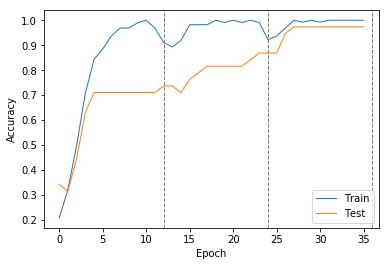

In [39]:
line_graph(
    values=(train_acc, valid_acc),
    labels=("Train", "Test"),
    x_guides=[i*EPOCHS_BODY for i in range(1, len(train_acc)//EPOCHS_BODY + 1)],
    x_name="Epoch",
    y_name="Accuracy",
)

**If the model performs well enough, we can stop the training / negative sampling here.**

If not, let's do hard negative sampling.

## 4. Score the model on *U* 

In [40]:
pred_outs = learn.get_preds(ds_type=DatasetType.Test)  # Note, 'Test' is our negative set U
pred_outs = np.array(pred_outs[0].tolist())  # Convert Tensor to np array
preds = np.argmax(pred_outs, axis=1)
print(f"Prediction labels on test set: {preds}")

Prediction labels on test set: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 0 3 3 3 3 3 3 3]


## 5. Hard negative mining

In [41]:
negative_class = data.classes.index('negative')

# Get top-n false classified images (by confidence)
wrong_ids = np.where(preds!=negative_class)[0]
wrong_ids_confs = [(i, pred_outs[i][preds[i]]) for i in wrong_ids]
wrong_ids_confs = sorted(wrong_ids_confs, key=lambda l:l[1], reverse=True)[:NEGATIVE_NUM]

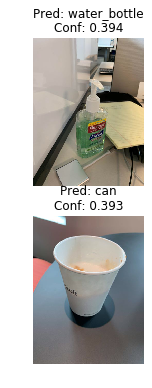

In [42]:
negative_sample_ids = [w[0] for w in wrong_ids_confs]
negative_sample_labels = [f"Pred: {data.classes[preds[w[0]]]}\nConf: {w[1]:.3f}" for w in wrong_ids_confs]
show_im_files(data.test_ds.items[negative_sample_ids], negative_sample_labels, rows=NEGATIVE_NUM//5)

## 6. Add hard negative samples to the training set *T*

We add the hard negative samples into the training set.

In [43]:
copy_files(data.test_ds.items[negative_sample_ids], data_path/'train'/'negative', remove=True)

In [44]:
data = (ImageList.from_folder(data_path)
        .split_by_folder()
        .label_from_folder()
        .add_test_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))
print(data.batch_stats)
learn.data = data

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (131 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negative,negative,negative,negative,negative
Path: /tmp/tmps0ewsrvt/data;

Valid: LabelList (38 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negative,negative,negative,negative,negative
Path: /tmp/tmps0ewsrvt/data;

Test: LabelList (29 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /tmp/tmps0ewsrvt/data>


Now, let's go **back** to the "[3. Train the model on T](#train)" and repeat the training and negative mining steps while we have a decent accuracy on `negative` samples

In [46]:
# Finally, show the number of repetitions you went through the negative mining
print(f"Ran {len(interpretations)} time(s)")

Ran 3 time(s)
